## Package

In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.SimpleModels import *
from architectures_28x28.ConvNet import ConvNet
from architectures_28x28.KANConvs_MLP import KANC_MLP
from architectures_28x28.KKAN import KKAN_Convolutional_Network
from architectures_28x28.conv_and_kan import NormalConvsKAN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [8]:
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

## Train & Test

In [9]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        optimizer: the optimizer to use (e.g. SGD)
        epoch: the current epoch
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        avg_loss: the average loss over the training set
    """

    model.to(device)
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    # print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    """
    Test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        test_loader: DataLoader for test data
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        test_loss: the average loss over the test set
        accuracy: the accuracy of the model on the test set
        precision: the precision of the model on the test set
        recall: the recall of the model on the test set
        f1: the f1 score of the model on the test set
    """

    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

In [10]:
def train_and_test_models(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    """
    Train and test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: the optimizer to use (e.g. SGD)
        criterion: the loss function (e.g. CrossEntropy)
        epochs: the number of epochs to train
        scheduler: the learning rate scheduler

    Returns:
        all_train_loss: a list of the average training loss for each epoch
        all_test_loss: a list of the average test loss for each epoch
        all_test_accuracy: a list of the accuracy for each epoch
        all_test_precision: a list of the precision for each epoch
        all_test_recall: a list of the recall for each epoch
        all_test_f1: a list of the f1 score for each epoch
    """
    # Track metrics
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []
    all_test_precision = []
    all_test_recall = []
    all_test_f1 = []
    
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        
        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        all_test_precision.append(test_precision)
        all_test_recall.append(test_recall)
        all_test_f1.append(test_f1)

        print(f'End of Epoch {epoch}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.0f}%')
        scheduler.step()
    
    return all_train_loss, all_test_loss, all_test_accuracy, all_test_precision, all_test_recall, all_test_f1

## Set Device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Common Models:
- SimpleCNN
- SimpleLinear
- ConvNet

In [12]:
model_SimpleCNN = SimpleCNN()
model_SimpleCNN.to(device)
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
criterion_SimpleCNN = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN, all_test_precision_SimpleCNN, all_test_recall_SimpleCNN, all_test_f1_SimpleCNN = train_and_test_models(model_SimpleCNN, device, train_loader, test_loader, optimizer_SimpleCNN, criterion_SimpleCNN, epochs=10, scheduler=scheduler_SimpleCNN)

100%|██████████| 938/938 [00:18<00:00, 51.11it/s]


End of Epoch 1: Train Loss: 0.446476, Test Loss: 0.0031, Accuracy: 9423.00%


100%|██████████| 938/938 [00:19<00:00, 48.69it/s]


End of Epoch 2: Train Loss: 0.154526, Test Loss: 0.0019, Accuracy: 9631.00%


100%|██████████| 938/938 [00:19<00:00, 48.23it/s]


End of Epoch 3: Train Loss: 0.114250, Test Loss: 0.0015, Accuracy: 9696.00%


100%|██████████| 938/938 [00:18<00:00, 50.22it/s]


End of Epoch 4: Train Loss: 0.098006, Test Loss: 0.0014, Accuracy: 9719.00%


100%|██████████| 938/938 [00:18<00:00, 49.72it/s]


End of Epoch 5: Train Loss: 0.088118, Test Loss: 0.0013, Accuracy: 9744.00%


100%|██████████| 938/938 [00:20<00:00, 45.85it/s]


End of Epoch 6: Train Loss: 0.082233, Test Loss: 0.0012, Accuracy: 9751.00%


100%|██████████| 938/938 [00:19<00:00, 47.86it/s]


End of Epoch 7: Train Loss: 0.078269, Test Loss: 0.0012, Accuracy: 9757.00%


100%|██████████| 938/938 [00:18<00:00, 51.50it/s]


End of Epoch 8: Train Loss: 0.074855, Test Loss: 0.0011, Accuracy: 9763.00%


100%|██████████| 938/938 [00:18<00:00, 50.55it/s]


End of Epoch 9: Train Loss: 0.072446, Test Loss: 0.0011, Accuracy: 9771.00%


100%|██████████| 938/938 [00:18<00:00, 51.10it/s]


End of Epoch 10: Train Loss: 0.070520, Test Loss: 0.0011, Accuracy: 9773.00%


In [13]:
model_SimpleLinear = SimpleLinear()
model_SimpleLinear.to(device)
optimizer_SimpleLinear = optim.AdamW(model_SimpleLinear.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleLinear = optim.lr_scheduler.ExponentialLR(optimizer_SimpleLinear, gamma=0.8)
criterion_SimpleLinear = nn.CrossEntropyLoss()
all_train_loss_SimpleLinear, all_test_loss_SimpleLinear, all_test_accuracy_SimpleLinear, all_test_precision_SimpleLinear, all_test_recall_SimpleLinear, all_test_f1_SimpleLinear = train_and_test_models(model_SimpleLinear, device, train_loader, test_loader, optimizer_SimpleLinear, criterion_SimpleLinear, epochs=10, scheduler=scheduler_SimpleLinear)


100%|██████████| 938/938 [00:16<00:00, 56.84it/s]


End of Epoch 1: Train Loss: 0.469323, Test Loss: 0.0053, Accuracy: 9016.00%


100%|██████████| 938/938 [00:15<00:00, 58.96it/s]


End of Epoch 2: Train Loss: 0.323453, Test Loss: 0.0048, Accuracy: 9122.00%


100%|██████████| 938/938 [00:16<00:00, 55.43it/s]


End of Epoch 3: Train Loss: 0.304603, Test Loss: 0.0047, Accuracy: 9134.00%


100%|██████████| 938/938 [00:16<00:00, 55.99it/s]


End of Epoch 4: Train Loss: 0.295433, Test Loss: 0.0044, Accuracy: 9216.00%


100%|██████████| 938/938 [00:16<00:00, 56.84it/s]


End of Epoch 5: Train Loss: 0.288024, Test Loss: 0.0045, Accuracy: 9195.00%


100%|██████████| 938/938 [00:16<00:00, 56.34it/s]


End of Epoch 6: Train Loss: 0.283512, Test Loss: 0.0044, Accuracy: 9201.00%


100%|██████████| 938/938 [00:17<00:00, 53.21it/s]


End of Epoch 7: Train Loss: 0.278999, Test Loss: 0.0044, Accuracy: 9196.00%


100%|██████████| 938/938 [00:17<00:00, 55.03it/s]


End of Epoch 8: Train Loss: 0.276076, Test Loss: 0.0043, Accuracy: 9223.00%


100%|██████████| 938/938 [00:17<00:00, 54.35it/s]


End of Epoch 9: Train Loss: 0.274303, Test Loss: 0.0044, Accuracy: 9198.00%


100%|██████████| 938/938 [00:17<00:00, 54.93it/s]


End of Epoch 10: Train Loss: 0.272233, Test Loss: 0.0043, Accuracy: 9204.00%


In [14]:
model_ConvNet = ConvNet()
model_ConvNet.to(device)
optimizer_ConvNet = optim.AdamW(model_ConvNet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_ConvNet = optim.lr_scheduler.ExponentialLR(optimizer_ConvNet, gamma=0.8)
criterion_ConvNet = nn.CrossEntropyLoss()
all_train_loss_ConvNet, all_test_loss_ConvNet, all_test_accuracy_ConvNet, all_test_precision_ConvNet, all_test_recall_ConvNet, all_test_f1_ConvNet = train_and_test_models(model_ConvNet, device, train_loader, test_loader, optimizer_ConvNet, criterion_ConvNet, epochs=10, scheduler=scheduler_ConvNet)


100%|██████████| 938/938 [00:19<00:00, 47.41it/s]


End of Epoch 1: Train Loss: 0.193771, Test Loss: 0.0007, Accuracy: 9867.00%


100%|██████████| 938/938 [00:18<00:00, 50.58it/s]


End of Epoch 2: Train Loss: 0.065570, Test Loss: 0.0005, Accuracy: 9882.00%


100%|██████████| 938/938 [00:20<00:00, 46.09it/s]


End of Epoch 3: Train Loss: 0.046082, Test Loss: 0.0004, Accuracy: 9916.00%


100%|██████████| 938/938 [00:19<00:00, 48.48it/s]


End of Epoch 4: Train Loss: 0.036865, Test Loss: 0.0003, Accuracy: 9946.00%


100%|██████████| 938/938 [00:19<00:00, 48.62it/s]


End of Epoch 5: Train Loss: 0.030380, Test Loss: 0.0003, Accuracy: 9942.00%


100%|██████████| 938/938 [00:20<00:00, 45.48it/s]


End of Epoch 6: Train Loss: 0.024910, Test Loss: 0.0003, Accuracy: 9943.00%


100%|██████████| 938/938 [00:21<00:00, 44.56it/s]


End of Epoch 7: Train Loss: 0.020596, Test Loss: 0.0003, Accuracy: 9951.00%


100%|██████████| 938/938 [00:20<00:00, 46.15it/s]


End of Epoch 8: Train Loss: 0.017014, Test Loss: 0.0003, Accuracy: 9948.00%


100%|██████████| 938/938 [00:18<00:00, 51.14it/s]


End of Epoch 9: Train Loss: 0.014493, Test Loss: 0.0003, Accuracy: 9949.00%


100%|██████████| 938/938 [00:19<00:00, 47.24it/s]


End of Epoch 10: Train Loss: 0.011788, Test Loss: 0.0003, Accuracy: 9946.00%


## Convolutional KAN

In [15]:
model_KKAN_Convolutional_Network = KKAN_Convolutional_Network(device = device)
model_KKAN_Convolutional_Network.to(device)
optimizer_KKAN_Convolutional_Network = optim.AdamW(model_KKAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KKAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KKAN_Convolutional_Network, gamma=0.8)
criterion_KKAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KKAN_Convolutional_Network, all_test_loss_KKAN_Convolutional_Network, all_test_accuracy_KKAN_Convolutional_Network, all_test_precision_KKAN_Convolutional_Network, all_test_recall_KKAN_Convolutional_Network, all_test_f1_KKAN_Convolutional_Network = train_and_test_models(model_KKAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KKAN_Convolutional_Network, criterion_KKAN_Convolutional_Network, epochs=10, scheduler=scheduler_KKAN_Convolutional_Network)


100%|██████████| 938/938 [02:59<00:00,  5.23it/s]


End of Epoch 1: Train Loss: 0.305586, Test Loss: 0.0013, Accuracy: 9764.00%


100%|██████████| 938/938 [02:57<00:00,  5.28it/s]


End of Epoch 2: Train Loss: 0.071651, Test Loss: 0.0010, Accuracy: 9821.00%


100%|██████████| 938/938 [02:44<00:00,  5.69it/s]


End of Epoch 3: Train Loss: 0.048442, Test Loss: 0.0008, Accuracy: 9844.00%


100%|██████████| 938/938 [02:43<00:00,  5.74it/s]


End of Epoch 4: Train Loss: 0.036533, Test Loss: 0.0007, Accuracy: 9865.00%


100%|██████████| 938/938 [02:43<00:00,  5.73it/s]


End of Epoch 5: Train Loss: 0.028562, Test Loss: 0.0007, Accuracy: 9860.00%


100%|██████████| 938/938 [03:40<00:00,  4.25it/s]  


End of Epoch 6: Train Loss: 0.023387, Test Loss: 0.0006, Accuracy: 9877.00%


100%|██████████| 938/938 [02:56<00:00,  5.32it/s]


End of Epoch 7: Train Loss: 0.019639, Test Loss: 0.0006, Accuracy: 9873.00%


100%|██████████| 938/938 [02:54<00:00,  5.39it/s]


End of Epoch 8: Train Loss: 0.016814, Test Loss: 0.0006, Accuracy: 9881.00%


100%|██████████| 938/938 [02:51<00:00,  5.48it/s]


End of Epoch 9: Train Loss: 0.014806, Test Loss: 0.0006, Accuracy: 9882.00%


100%|██████████| 938/938 [02:52<00:00,  5.43it/s]


End of Epoch 10: Train Loss: 0.013266, Test Loss: 0.0006, Accuracy: 9877.00%


In [16]:
model_KANC_MLP= KANC_MLP(device = device)
model_KANC_MLP.to(device)
optimizer_KANC_MLP = optim.AdamW(model_KANC_MLP.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KANC_MLP = optim.lr_scheduler.ExponentialLR(optimizer_KANC_MLP, gamma=0.8)
criterion_KANC_MLP = nn.CrossEntropyLoss()

all_train_loss_KANC_MLP, all_test_loss_KANC_MLP, all_test_accuracy_KANC_MLP, all_test_precision_KANC_MLP, all_test_recall_KANC_MLP, all_test_f1_KANC_MLP = train_and_test_models(model_KANC_MLP, device, train_loader, test_loader, optimizer_KANC_MLP, criterion_KANC_MLP, epochs=10, scheduler=scheduler_KANC_MLP)


100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


End of Epoch 1: Train Loss: 0.222111, Test Loss: 0.0012, Accuracy: 9759.00%


100%|██████████| 938/938 [03:00<00:00,  5.19it/s]


End of Epoch 2: Train Loss: 0.070597, Test Loss: 0.0010, Accuracy: 9798.00%


100%|██████████| 938/938 [02:55<00:00,  5.35it/s]


End of Epoch 3: Train Loss: 0.054762, Test Loss: 0.0008, Accuracy: 9835.00%


100%|██████████| 938/938 [02:59<00:00,  5.23it/s]


End of Epoch 4: Train Loss: 0.046318, Test Loss: 0.0007, Accuracy: 9835.00%


100%|██████████| 938/938 [03:08<00:00,  4.97it/s]


End of Epoch 5: Train Loss: 0.040511, Test Loss: 0.0008, Accuracy: 9847.00%


100%|██████████| 938/938 [03:00<00:00,  5.18it/s]


End of Epoch 6: Train Loss: 0.035918, Test Loss: 0.0007, Accuracy: 9850.00%


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


End of Epoch 7: Train Loss: 0.032204, Test Loss: 0.0007, Accuracy: 9862.00%


100%|██████████| 938/938 [03:02<00:00,  5.13it/s]


End of Epoch 8: Train Loss: 0.029849, Test Loss: 0.0008, Accuracy: 9851.00%


100%|██████████| 938/938 [02:52<00:00,  5.44it/s]


End of Epoch 9: Train Loss: 0.027796, Test Loss: 0.0007, Accuracy: 9857.00%


100%|██████████| 938/938 [02:52<00:00,  5.44it/s]


End of Epoch 10: Train Loss: 0.025835, Test Loss: 0.0007, Accuracy: 9850.00%


In [18]:
model_Convs_and_KAN= NormalConvsKAN()
model_Convs_and_KAN.to(device)
optimizer_Convs_and_KAN = optim.AdamW(model_Convs_and_KAN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_Convs_and_KAN = optim.lr_scheduler.ExponentialLR(optimizer_Convs_and_KAN, gamma=0.8)
criterion_Convs_and_KAN = nn.CrossEntropyLoss()

all_train_loss_Convs_and_KAN, all_test_loss_Convs_and_KAN, all_test_accuracy_Convs_and_KAN, all_test_precision_Convs_and_KAN, all_test_recall_Convs_and_KAN, all_test_f1_Convs_and_KAN = train_and_test_models(model_Convs_and_KAN, device, train_loader, test_loader, optimizer_Convs_and_KAN, criterion_Convs_and_KAN, epochs=10, scheduler=scheduler_Convs_and_KAN)


100%|██████████| 938/938 [00:21<00:00, 44.19it/s]


End of Epoch 1: Train Loss: 0.445520, Test Loss: 0.0025, Accuracy: 9544.00%


100%|██████████| 938/938 [00:21<00:00, 43.42it/s]


End of Epoch 2: Train Loss: 0.128280, Test Loss: 0.0016, Accuracy: 9670.00%


100%|██████████| 938/938 [00:20<00:00, 45.69it/s]


End of Epoch 3: Train Loss: 0.098351, Test Loss: 0.0013, Accuracy: 9730.00%


100%|██████████| 938/938 [00:21<00:00, 43.47it/s]


End of Epoch 4: Train Loss: 0.085619, Test Loss: 0.0012, Accuracy: 9744.00%


100%|██████████| 938/938 [00:20<00:00, 46.87it/s]


End of Epoch 5: Train Loss: 0.077765, Test Loss: 0.0012, Accuracy: 9763.00%


100%|██████████| 938/938 [00:19<00:00, 48.06it/s]


End of Epoch 6: Train Loss: 0.072558, Test Loss: 0.0012, Accuracy: 9772.00%


100%|██████████| 938/938 [00:20<00:00, 46.80it/s]


End of Epoch 7: Train Loss: 0.068612, Test Loss: 0.0011, Accuracy: 9776.00%


100%|██████████| 938/938 [00:20<00:00, 45.74it/s]


End of Epoch 8: Train Loss: 0.065873, Test Loss: 0.0011, Accuracy: 9779.00%


100%|██████████| 938/938 [00:20<00:00, 45.99it/s]


End of Epoch 9: Train Loss: 0.063479, Test Loss: 0.0011, Accuracy: 9787.00%


100%|██████████| 938/938 [00:19<00:00, 47.68it/s]


End of Epoch 10: Train Loss: 0.062006, Test Loss: 0.0010, Accuracy: 9781.00%


## Results

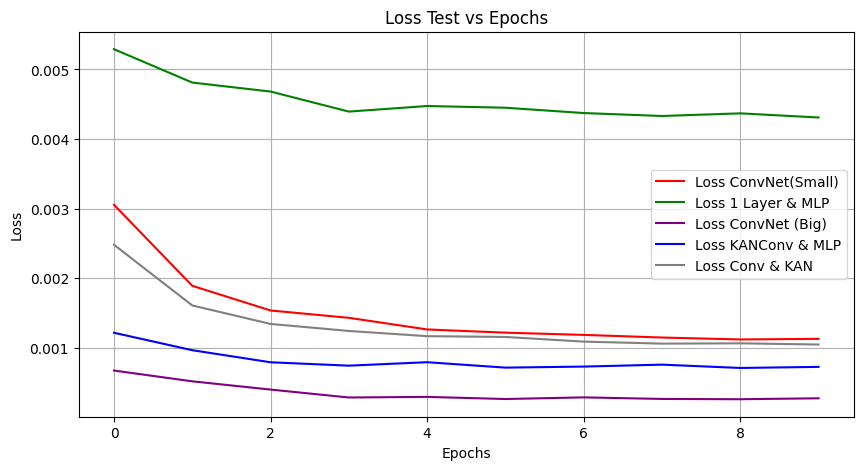

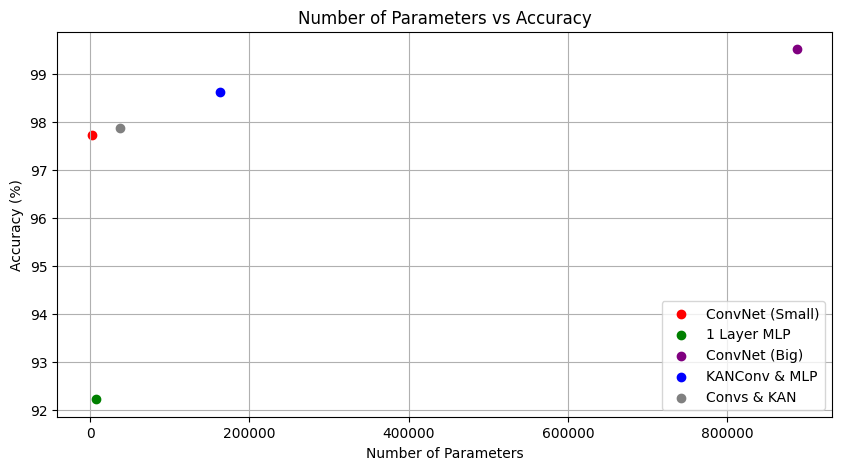

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

plt.figure(figsize=(10, 5))
plt.plot(all_test_loss_SimpleCNN, label='Loss ConvNet(Small)', color='red')
plt.plot(all_test_loss_SimpleLinear, label='Loss 1 Layer & MLP', color='green')
plt.plot(all_test_loss_ConvNet, label='Loss ConvNet (Big)', color='purple')
plt.plot(all_test_loss_KANC_MLP, label='Loss KANConv & MLP', color='blue')
plt.plot(all_test_loss_Convs_and_KAN, label='Loss Conv & KAN', color='gray')
# plt.plot(all_test_loss_KKAN_Convolutional_Network, label='Loss KKAN', color='orange')

plt.title('Loss Test vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.scatter(count_parameters(model_SimpleCNN), max(all_test_accuracy_SimpleCNN), color='red', label='ConvNet (Small)')
plt.scatter(count_parameters(model_SimpleLinear), max(all_test_accuracy_SimpleLinear), color='green', label='1 Layer MLP')
plt.scatter(count_parameters(model_ConvNet), max(all_test_accuracy_ConvNet), color='purple', label='ConvNet (Big)')
plt.scatter(count_parameters(model_KANC_MLP), max(all_test_accuracy_KANC_MLP), color='blue', label='KANConv & MLP')
plt.scatter(count_parameters(model_Convs_and_KAN), max(all_test_accuracy_Convs_and_KAN), color='grey', label='Convs & KAN')
# plt.scatter(count_parameters(model_KKAN_Convolutional_Network), max(all_test_loss_KKAN_Convolutional_Network), color='orange', label='KKAN')

plt.title('Number of Parameters vs Accuracy')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.legend() 
plt.grid(True)
plt.show()


In [30]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

accs = []
precision = []
recall = []
f1s = []
params_counts = []
models = [model_SimpleLinear,model_SimpleCNN,model_ConvNet,model_KANC_MLP,model_Convs_and_KAN , model_KKAN_Convolutional_Network]
all_accuracys = [all_test_accuracy_SimpleLinear,all_test_accuracy_SimpleCNN,all_test_accuracy_ConvNet,all_test_accuracy_KANC_MLP,all_test_accuracy_Convs_and_KAN, all_test_accuracy_KKAN_Convolutional_Network]
all_precision = [all_test_precision_SimpleLinear,all_test_precision_SimpleCNN,all_test_precision_ConvNet,all_test_precision_KANC_MLP,all_test_precision_Convs_and_KAN, all_test_precision_KKAN_Convolutional_Network]
all_recall = [all_test_recall_SimpleLinear,all_test_recall_SimpleCNN,all_test_recall_ConvNet,all_test_recall_KANC_MLP,all_test_recall_Convs_and_KAN, all_test_recall_KKAN_Convolutional_Network]
all_f1s = [all_test_f1_SimpleLinear,all_test_f1_SimpleCNN,all_test_f1_ConvNet,all_test_f1_KANC_MLP,all_test_f1_Convs_and_KAN, all_test_f1_KKAN_Convolutional_Network]

for i,m in enumerate(models):
    index = np.argmax(all_accuracys[i])
    params_counts.append(count_parameters(models[i]))
    accs.append(all_accuracys[i][index])
    precision.append(all_precision[i][index])
    recall.append(all_recall[i][index])
    f1s.append(all_f1s[i][index])

df = pd.DataFrame({"Test Accuracy":[accs],
                    "Test Precision":[precision],
                    "Test Recall":[recall],
                    "Test F1 Score":[f1s],
                    "Number of Parameters":[params_counts],
                 },index = ["1 Layer MLP","ConvNet (Small)","ConvNet (Big)","KANConv & MLP", "KANConv & KAN","KKAN"])#Rows
df = df.style.apply(highlight_max, subset=df.columns[:], axis=1).format('{:.3f}')

In [31]:
df

ValueError: ('Lengths must match to compare', (5,), (6,))

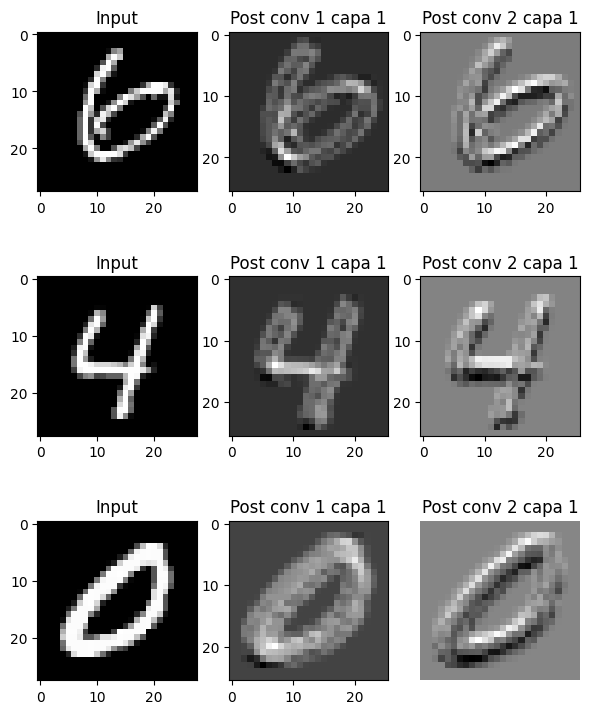

In [17]:
rows = 3
fig, ax  = plt.subplots(nrows = rows ,ncols = 3,figsize =(7,9))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = model_KANC_MLP.conv1.forward(img.unsqueeze(0).to(device))
        #print(post_conv[0,0].shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("Input")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post conv 1 capa 1")
        ax[row][2].imshow(post_conv[0,1].cpu(), cmap="gray")
        ax[row][2].set_title("Post conv 2 capa 1")

torch.Size([1, 25, 11, 11])
torch.Size([1, 25, 11, 11])
torch.Size([1, 25, 11, 11])


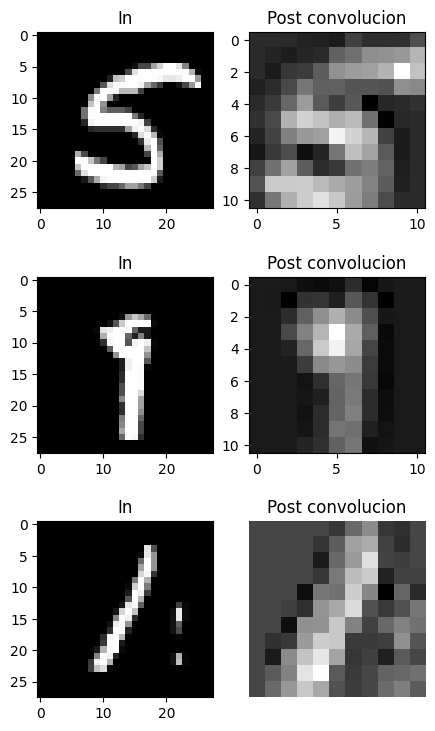

In [18]:
rows =3
fig, ax  = plt.subplots(nrows = rows ,ncols = 2,figsize =(5,9))
pool = nn.MaxPool2d(kernel_size=(2, 2))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = pool(model.conv1.forward(img.unsqueeze(0).to(device)))
        post_conv = model.conv2.forward(post_conv) 
        
        print(post_conv.shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("In")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post convolucion")


In [20]:
from architectures_28x28.SuperCKAN import SuperCKAN
device = "cuda"
model_SuperCKAN = SuperCKAN(device = device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model_SuperCKAN))
model_SuperCKAN.to(device)
optimizer_SuperCKAN = optim.AdamW(model_SuperCKAN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SuperCKAN = optim.lr_scheduler.ExponentialLR(optimizer_SuperCKAN, gamma=0.8)
criterion_SuperCKAN = nn.CrossEntropyLoss()

all_train_loss_SuperCKAN, all_test_loss_SuperCKAN, all_test_accuracy_SuperCKAN, all_test_precision_SuperCKAN, all_test_recall_SuperCKAN, all_test_f1_SuperCKAN = train_and_test_models(model_SuperCKAN, device, train_loader, test_loader, optimizer_SuperCKAN, criterion_SuperCKAN, epochs=10, scheduler=scheduler_SuperCKAN)


601770


  0%|          | 0/938 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 